# Sentiment_Analysis_Movie_Review

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
!pip install wordcloud > /dev/null

In [2]:
!pip install emoji > /dev/null

In [3]:
import math

import numpy as np
import pandas as pd
import re
import os, sys
import time
import emoji

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from wordcloud import WordCloud

from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyClassifier

import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from lightgbm import LGBMClassifier

import torch
import transformers

import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [5]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [6]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [7]:
df_reviews.shape

(47331, 17)

In [8]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

<AxesSubplot:>

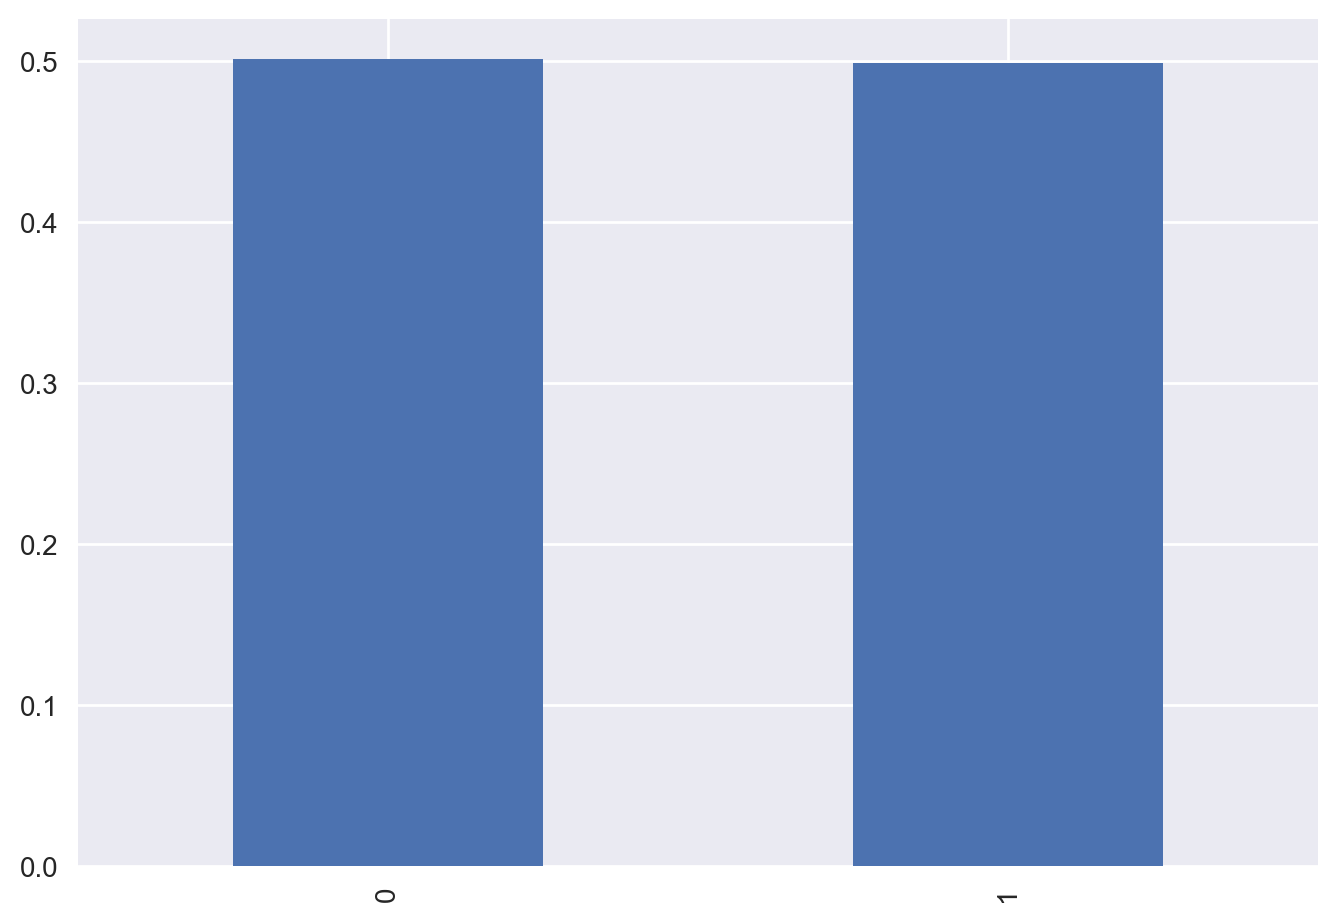

In [10]:
df_reviews['pos'].value_counts(normalize=True).plot(kind='bar')

In [11]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


In [12]:
def missing_values(data):
    df = pd.DataFrame()
    for col in list(data):
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
        zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
        
        df = df.append(pd.DataFrame([col, len(unique_values), nans, zeros]).T, ignore_index = True)
    return df.rename(columns = {0: 'variable', 
1: 'Unique values',
2: 'Nan %',
3: 'Zeros %', 
4: 'empty'}).sort_values('Nan %', ascending=False)

missing_values(df_reviews)

,variable,Unique values,Nan %,Zeros %
0,tconst,6648,0.0,0.0
9,average_rating,84,0.0,0.0
15,ds_part,2,0.0,0.0
14,pos,2,0.0,50.1
13,sp,2,0.0,0.0
12,rating,8,0.0,0.0
11,review,47240,0.0,0.0
10,votes,3749,0.0,0.0
8,genres,585,0.0,0.0
1,title_type,10,0.0,0.0


### Observations:

1. No null values but zero values are present.
2. Pos values of positive and negative are balanced. 
3. The average rating is at 6, the lowest rating at 1, and the highest at 9. 
4. The maximum votes reached 1.7 million.
5. The oldest review was for a movie released in 1894 while the latest review for a movie released in 2010. 

## EDA

Let's check the number of movies and reviews over years.

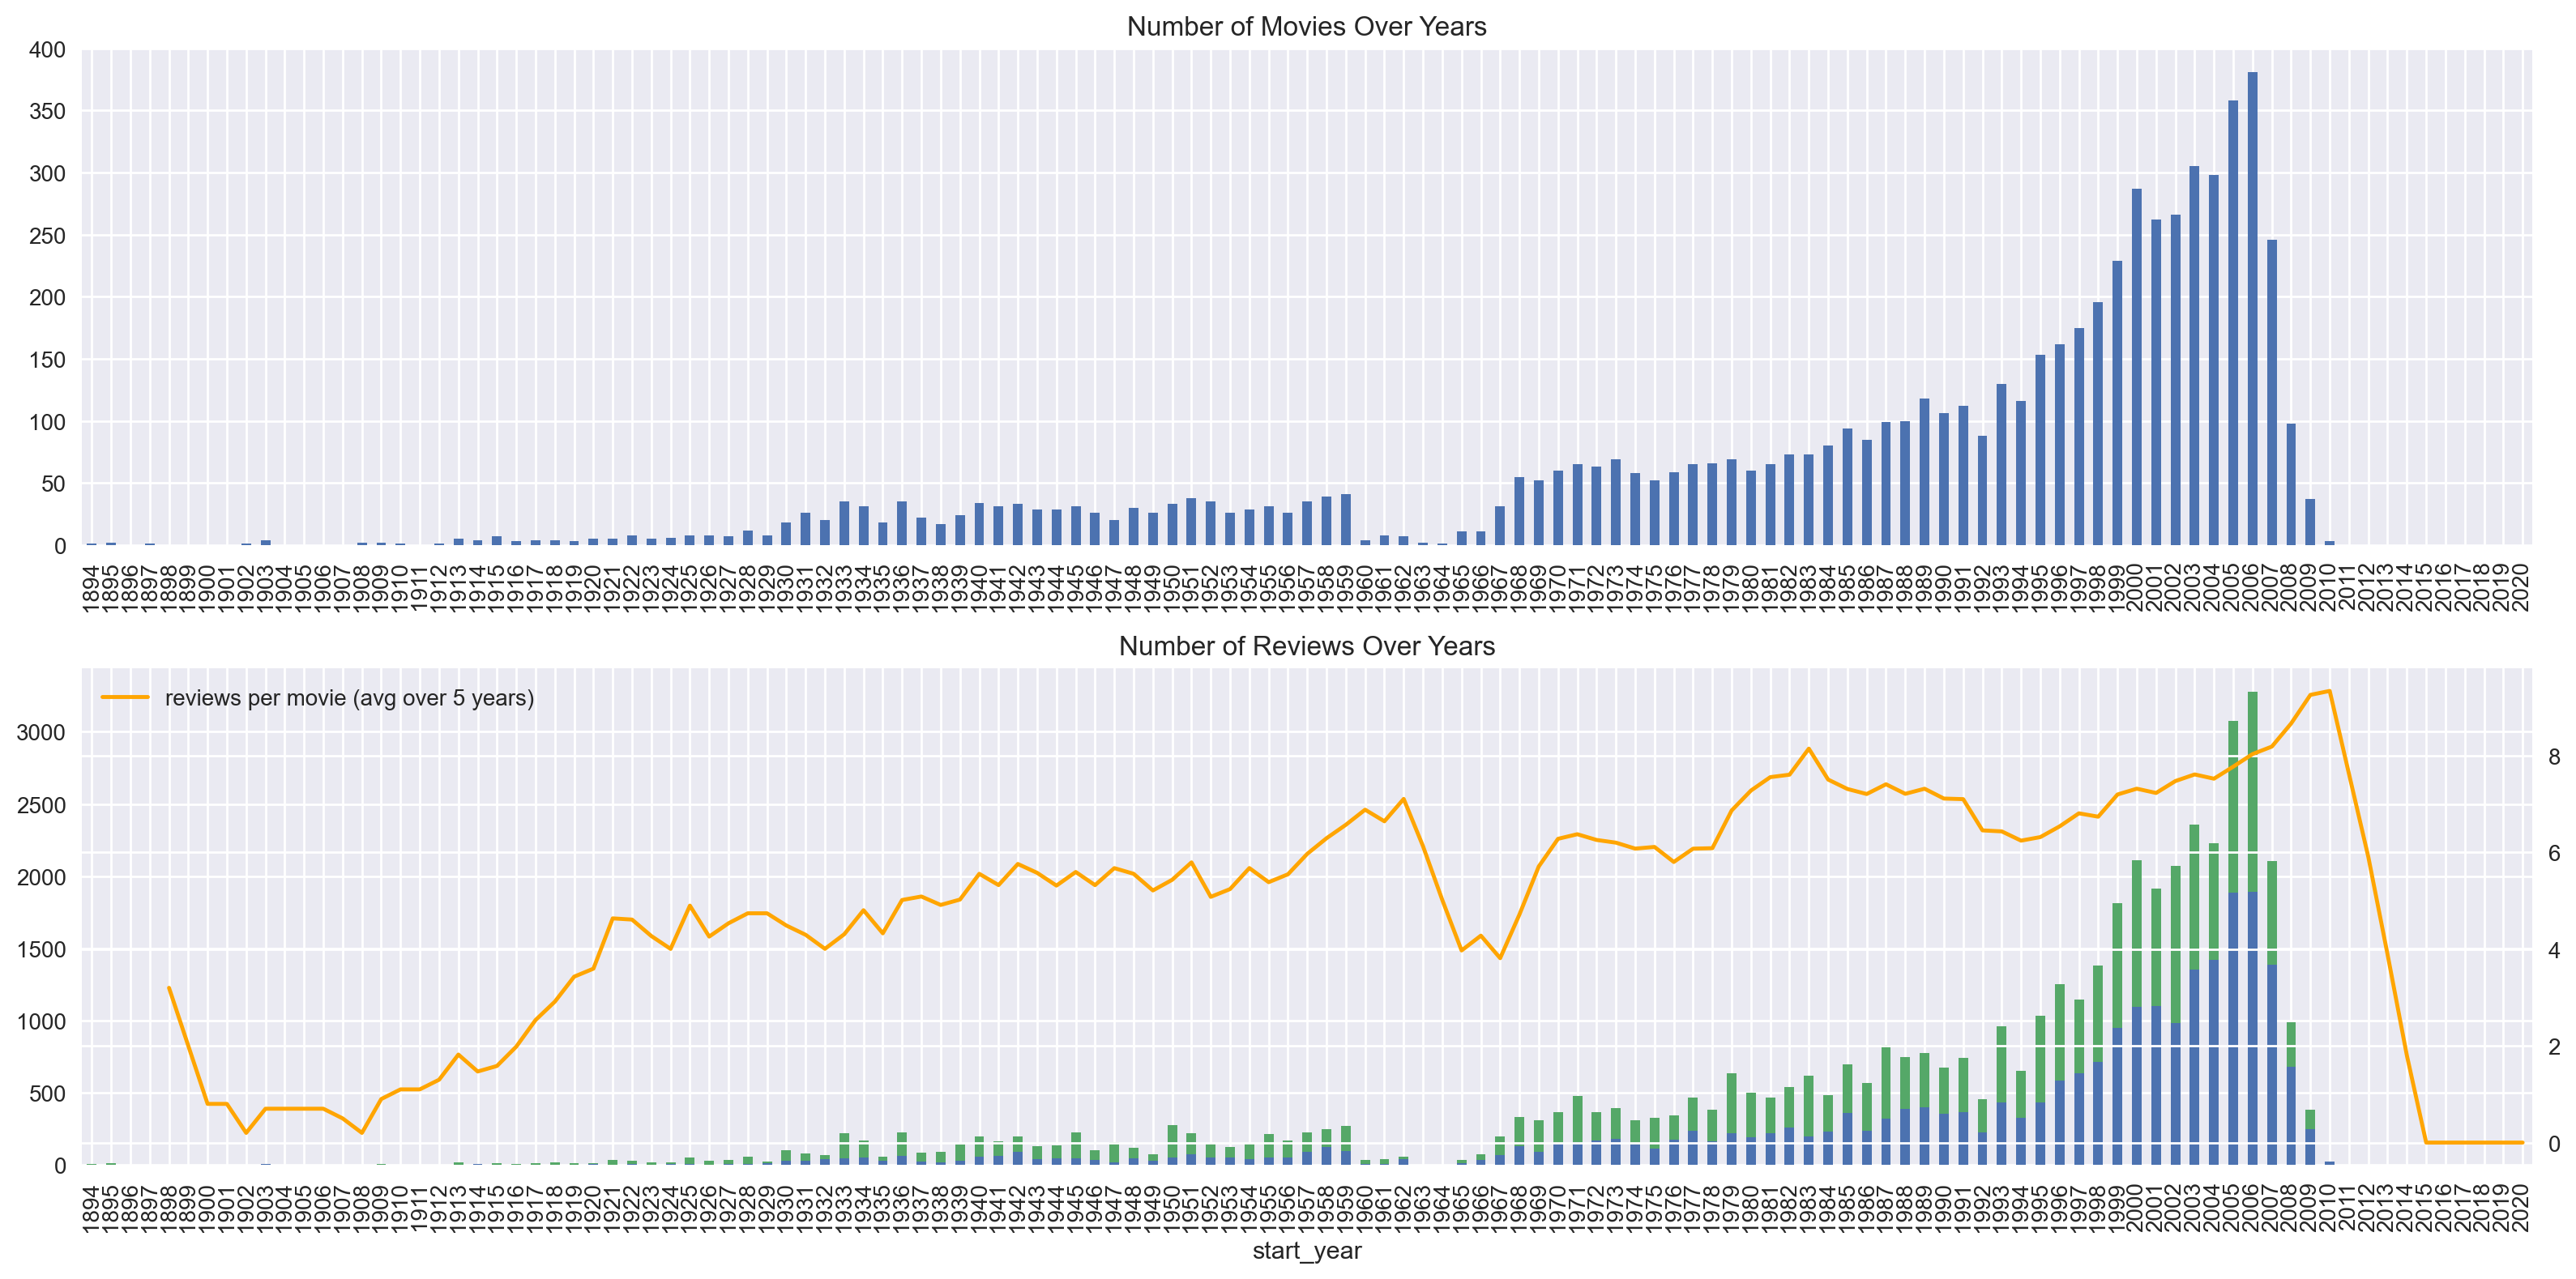

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

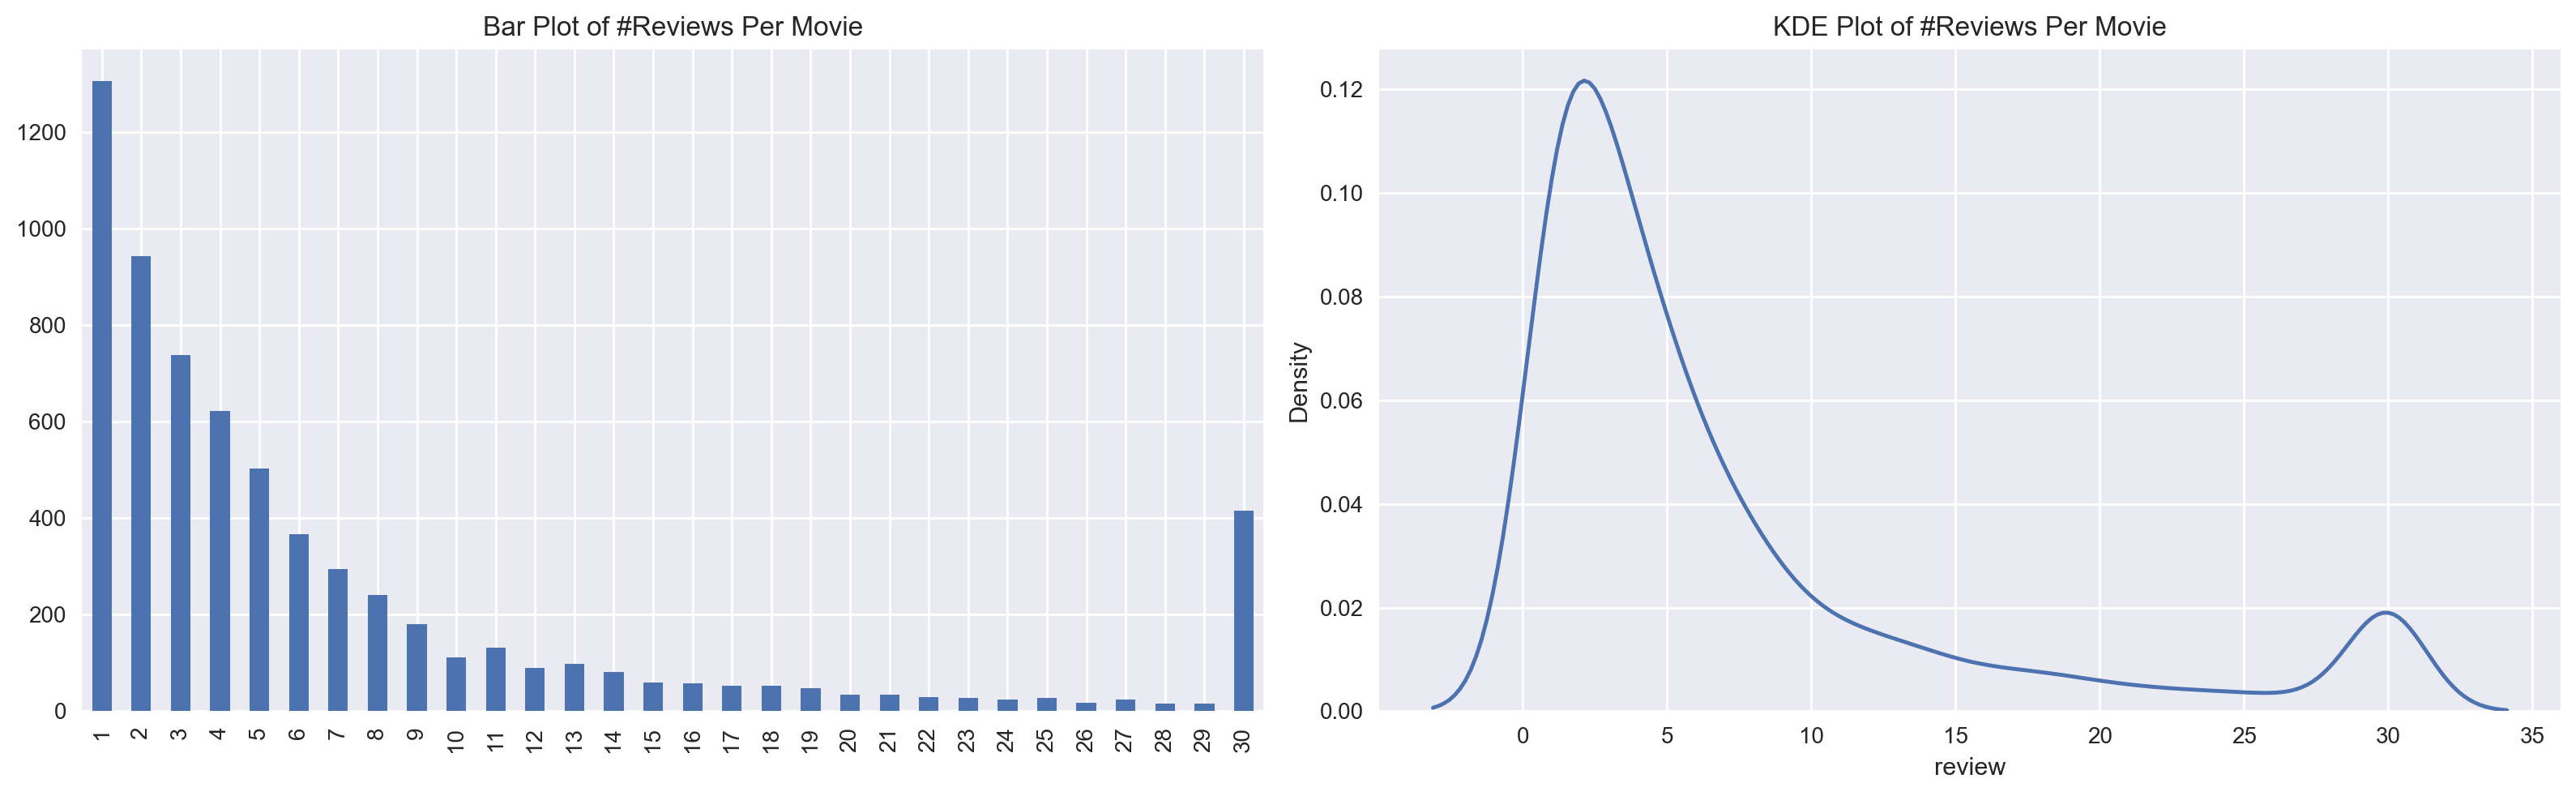

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

0    23715
1    23616
Name: pos, dtype: int64

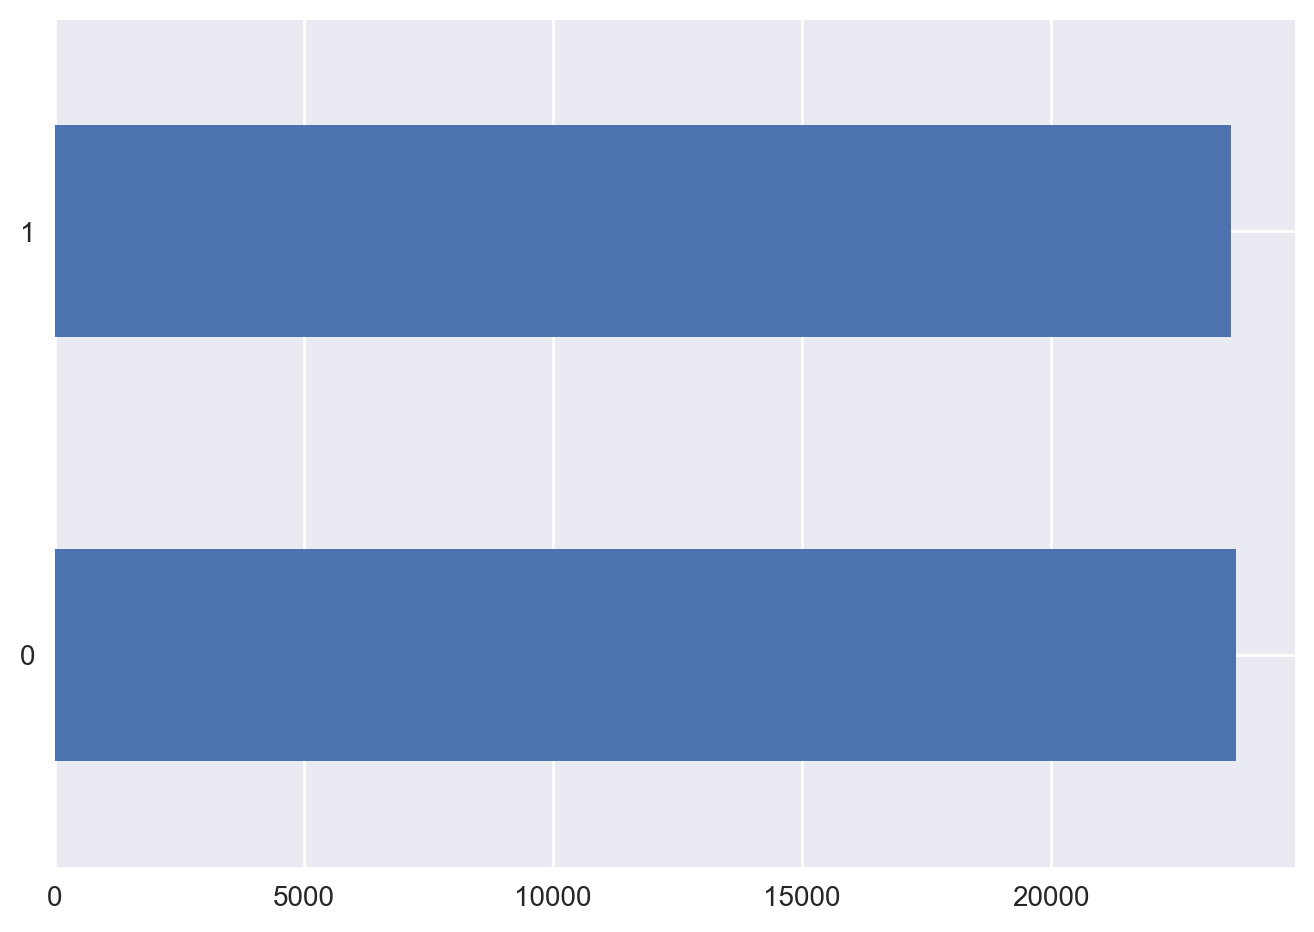

In [15]:
df_reviews['pos'].value_counts().plot(kind='barh')
df_reviews['pos'].value_counts()

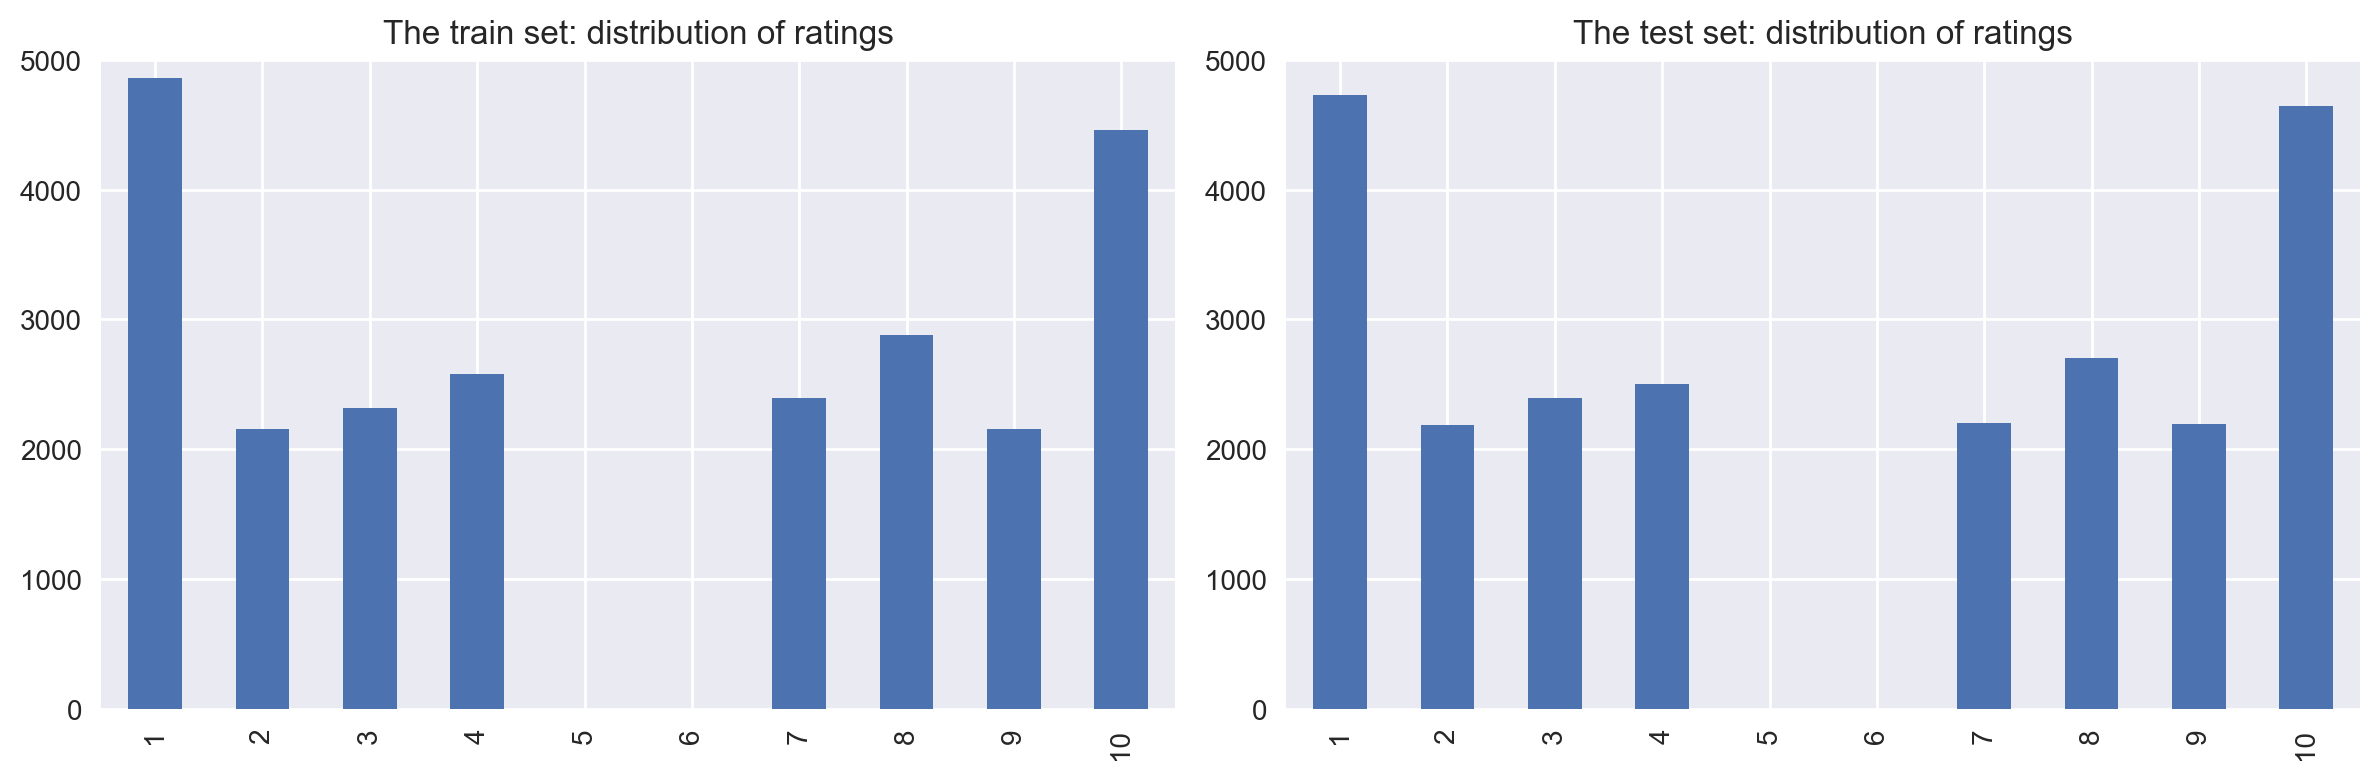

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

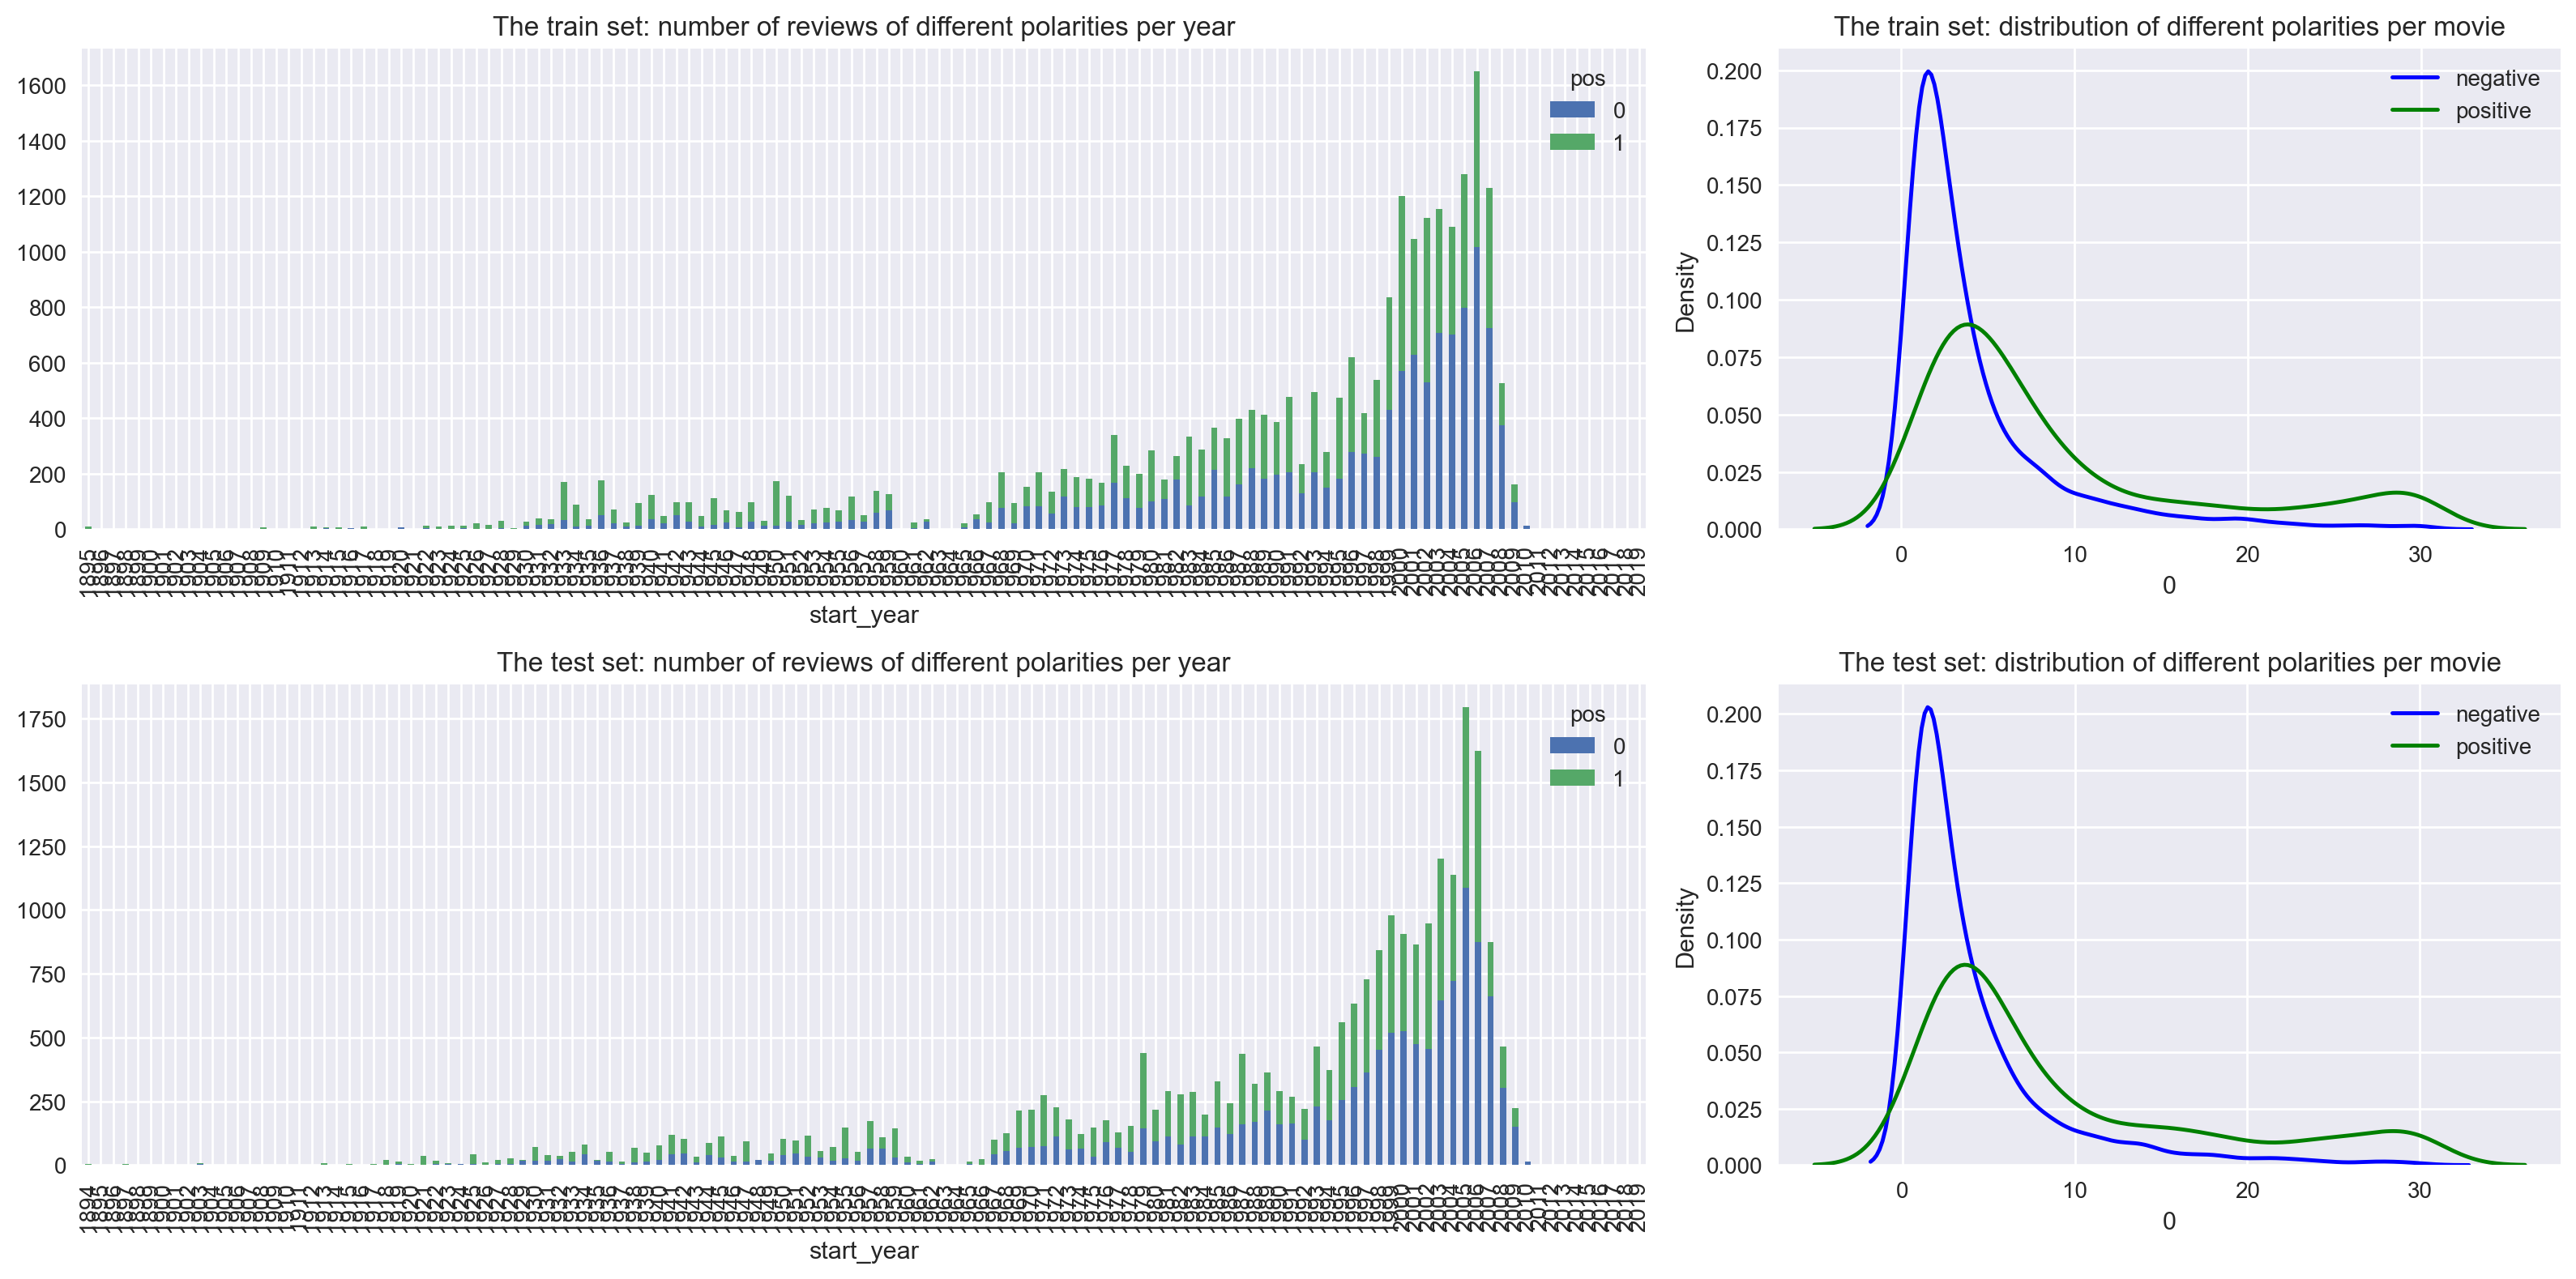

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

### Word Cloud of Positive Reviews

In [18]:
def create_word_cloud(df, target, val=1, is_filter=True, title=None):
    """
    Cerate word cloud of positive and negative reviews
    """
    text = ''
    if is_filter:
        pat = re.compile(r'movie|film|saw|really|watched|first|one|time|s|even')
        text = " ".join(re.sub(pat, '', review) for review in df[df[target] == val]['review'])
    else:
        text = " ".join(review for review in df[df[target] == val]['review'])
    wc = WordCloud(collocations=False, background_color='white').generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

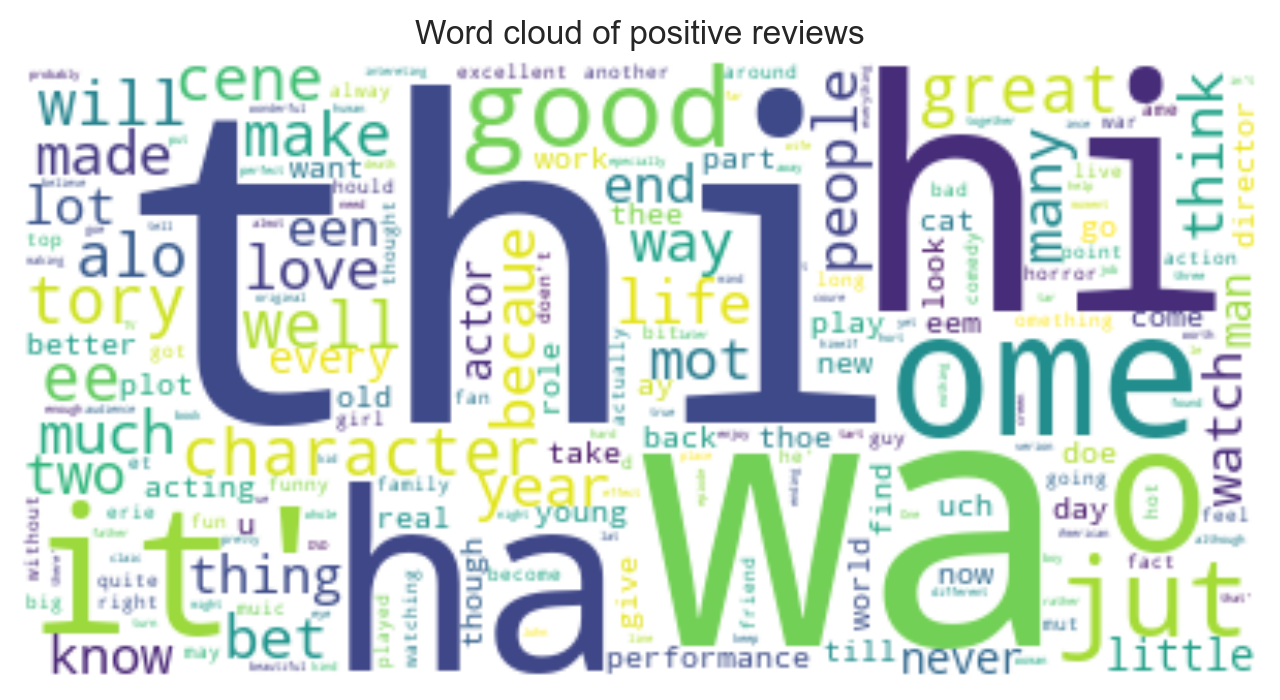

In [19]:
create_word_cloud(df_reviews, 'pos', val=1, is_filter=True, title='Word cloud of positive reviews')

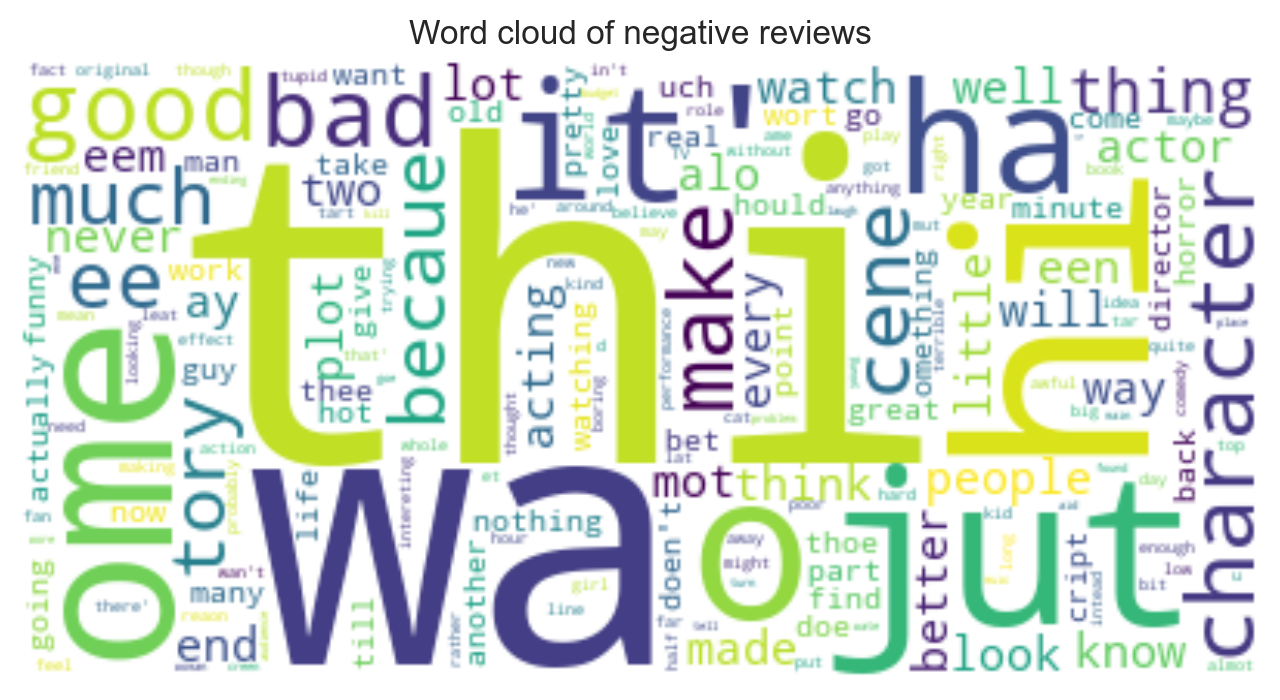

In [20]:
create_word_cloud(df_reviews, 'pos', val=0, is_filter=True, title='Word cloud of negative reviews')

### Observations
1. The classes in Pos are balanced.
2. Majority of the movies was released in 2016.
3. Most of the movies have one review. 30 movies though have about 400 reviews individually. 
4. The distribution of polarities of movie reviews are similar.
5. The distribution of ratings in both the train and test sets are similar. 
6. The word clouds of either positive and negative doesn't reveal any interesting words.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [21]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [22]:
lemmatizer = WordNetLemmatizer()

In [23]:
def clean_reviews(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\']', ' ', text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = re.sub(r'\s+', ' ', text)
    return text

In [24]:
%%time
df_reviews['reviews_norm'] = df_reviews['review'].apply(clean_reviews)

CPU times: user 6.69 s, sys: 0 ns, total: 6.69 s
Wall time: 6.69 s


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [25]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_y = df_reviews_train['pos']
test_y = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

In [26]:

def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], 
                early_stopping_rounds=50, verbose=False):
    np.random.seed(42)
    best_score = 0
    start_time = time.time()
    
    if model_str == 'dummy':
        model.fit(train_X, train_y)
        preds = model.predict(train_X)
        best_score = f1_score(train_y, preds)
        return model, best_score, np.round(time.time() - start_time, 2)
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'lgbm':
        gs.best_estimator_.fit(train_X, train_y, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_score = f1_score(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_score, np.round(end_time, 2)

### Model 0 - Constant

In [27]:
dc = DummyClassifier()
best_dc_model, best_dc_f1, best_dc_time = build_model(dc, df_reviews_train['reviews_norm'], train_y, 
                                                        df_reviews_test['reviews_norm'], test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=2, model_str='dummy')

In [28]:
best_dc_f1

0.0

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


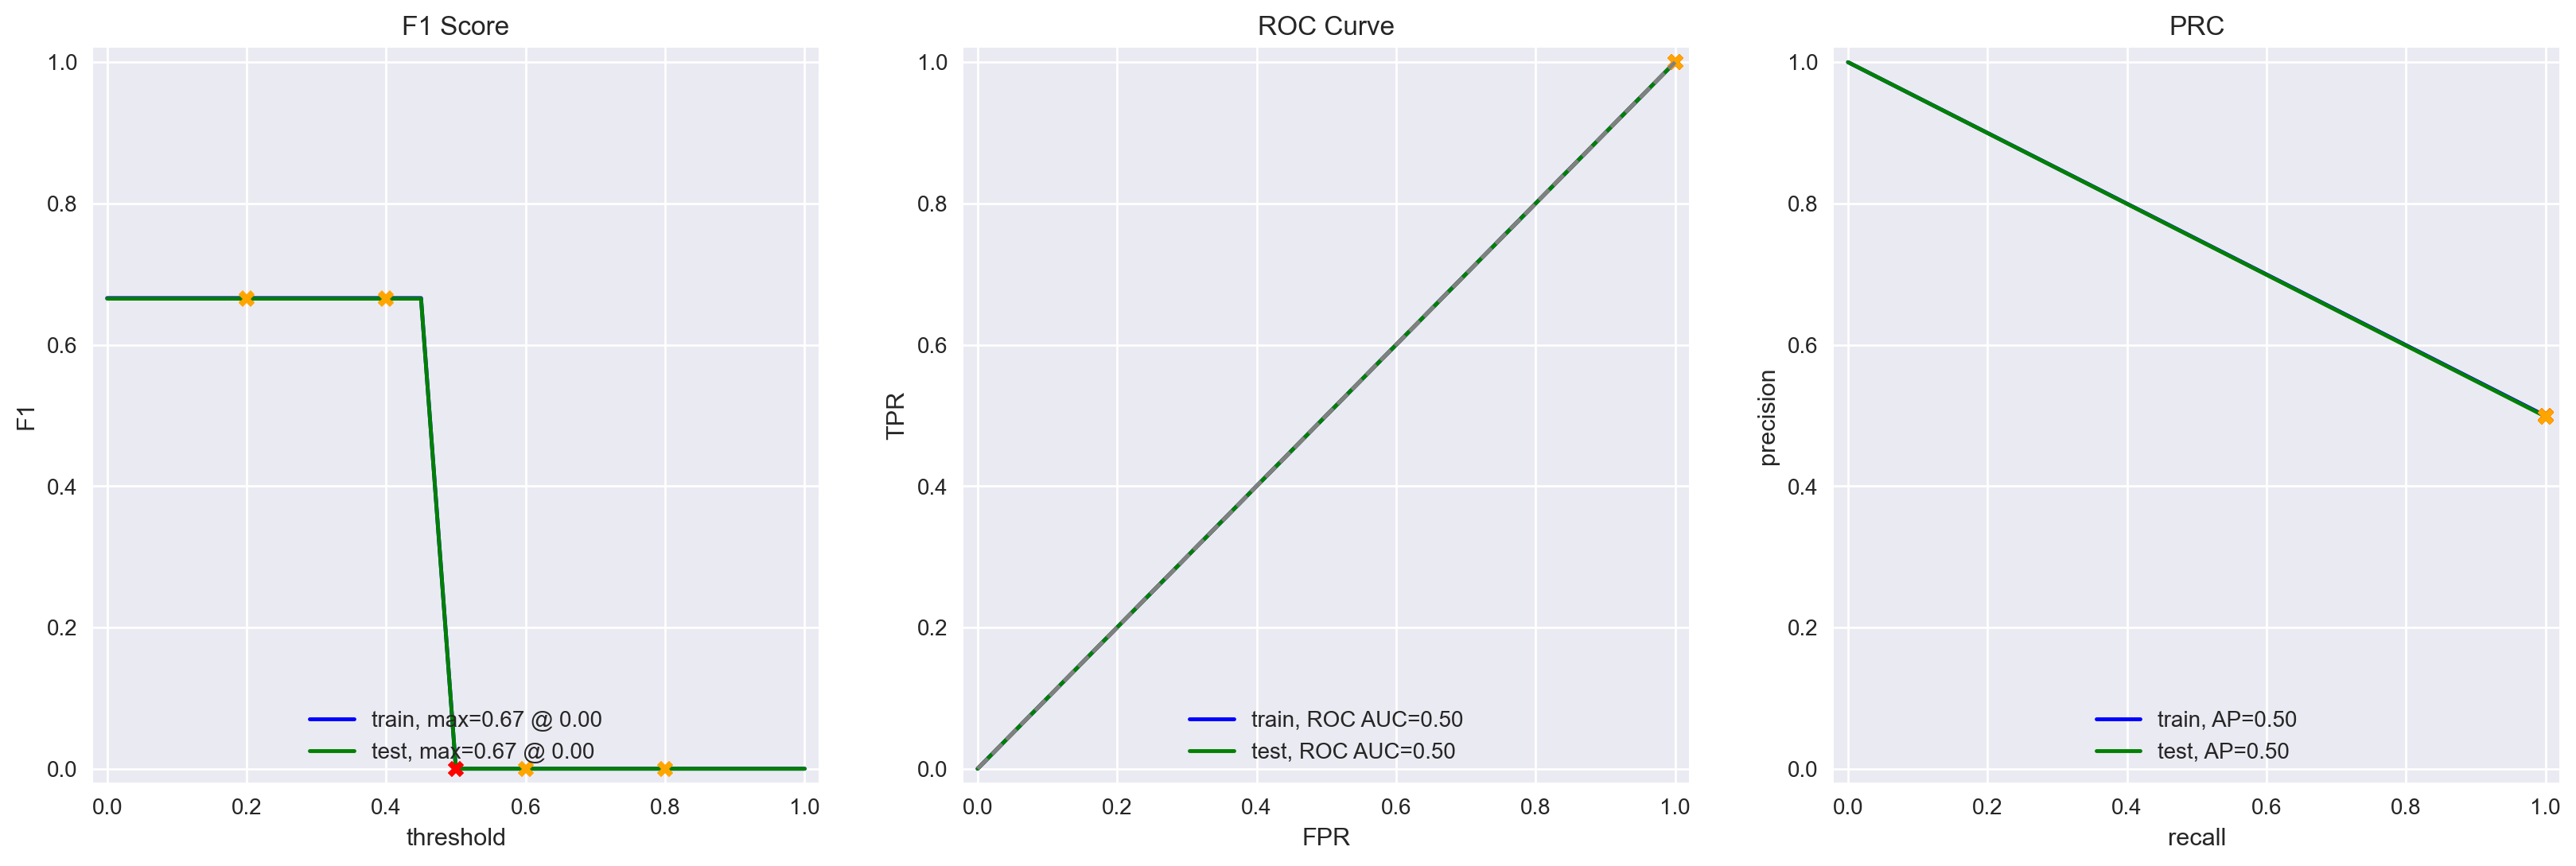

In [29]:
evaluate_model(best_dc_model, df_reviews_train['reviews_norm'], train_y, df_reviews_test['reviews_norm'], test_y)

### Observations:

* The dummy classifier performs good.

### Model 1 - NLTK, TF-IDF and LR

### TF-IDF

In [30]:
def text_preprocessing_1(text):
    tokens = word_tokenize(text)
    return " ".join(lemmatizer.lemmatize(token) for token in tokens)

In [31]:
%%time
df_reviews_train['reviews_nltk'] = df_reviews_train['reviews_norm'].apply(text_preprocessing_1)
df_reviews_test['reviews_nltk'] = df_reviews_test['reviews_norm'].apply(text_preprocessing_1)

CPU times: user 1min 1s, sys: 72 ms, total: 1min 1s
Wall time: 1min 1s


In [32]:
%%time
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
train_X = tfidf_vectorizer_1.fit_transform(df_reviews_train['reviews_nltk'])
test_X = tfidf_vectorizer_1.transform(df_reviews_test['reviews_nltk'])

CPU times: user 5.4 s, sys: 3.92 ms, total: 5.4 s
Wall time: 5.4 s


In [33]:
lr = LogisticRegression()
best_lr_model, best_lr_f1, best_lr_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

In [34]:
best_lr_f1

0.8805154903132201

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


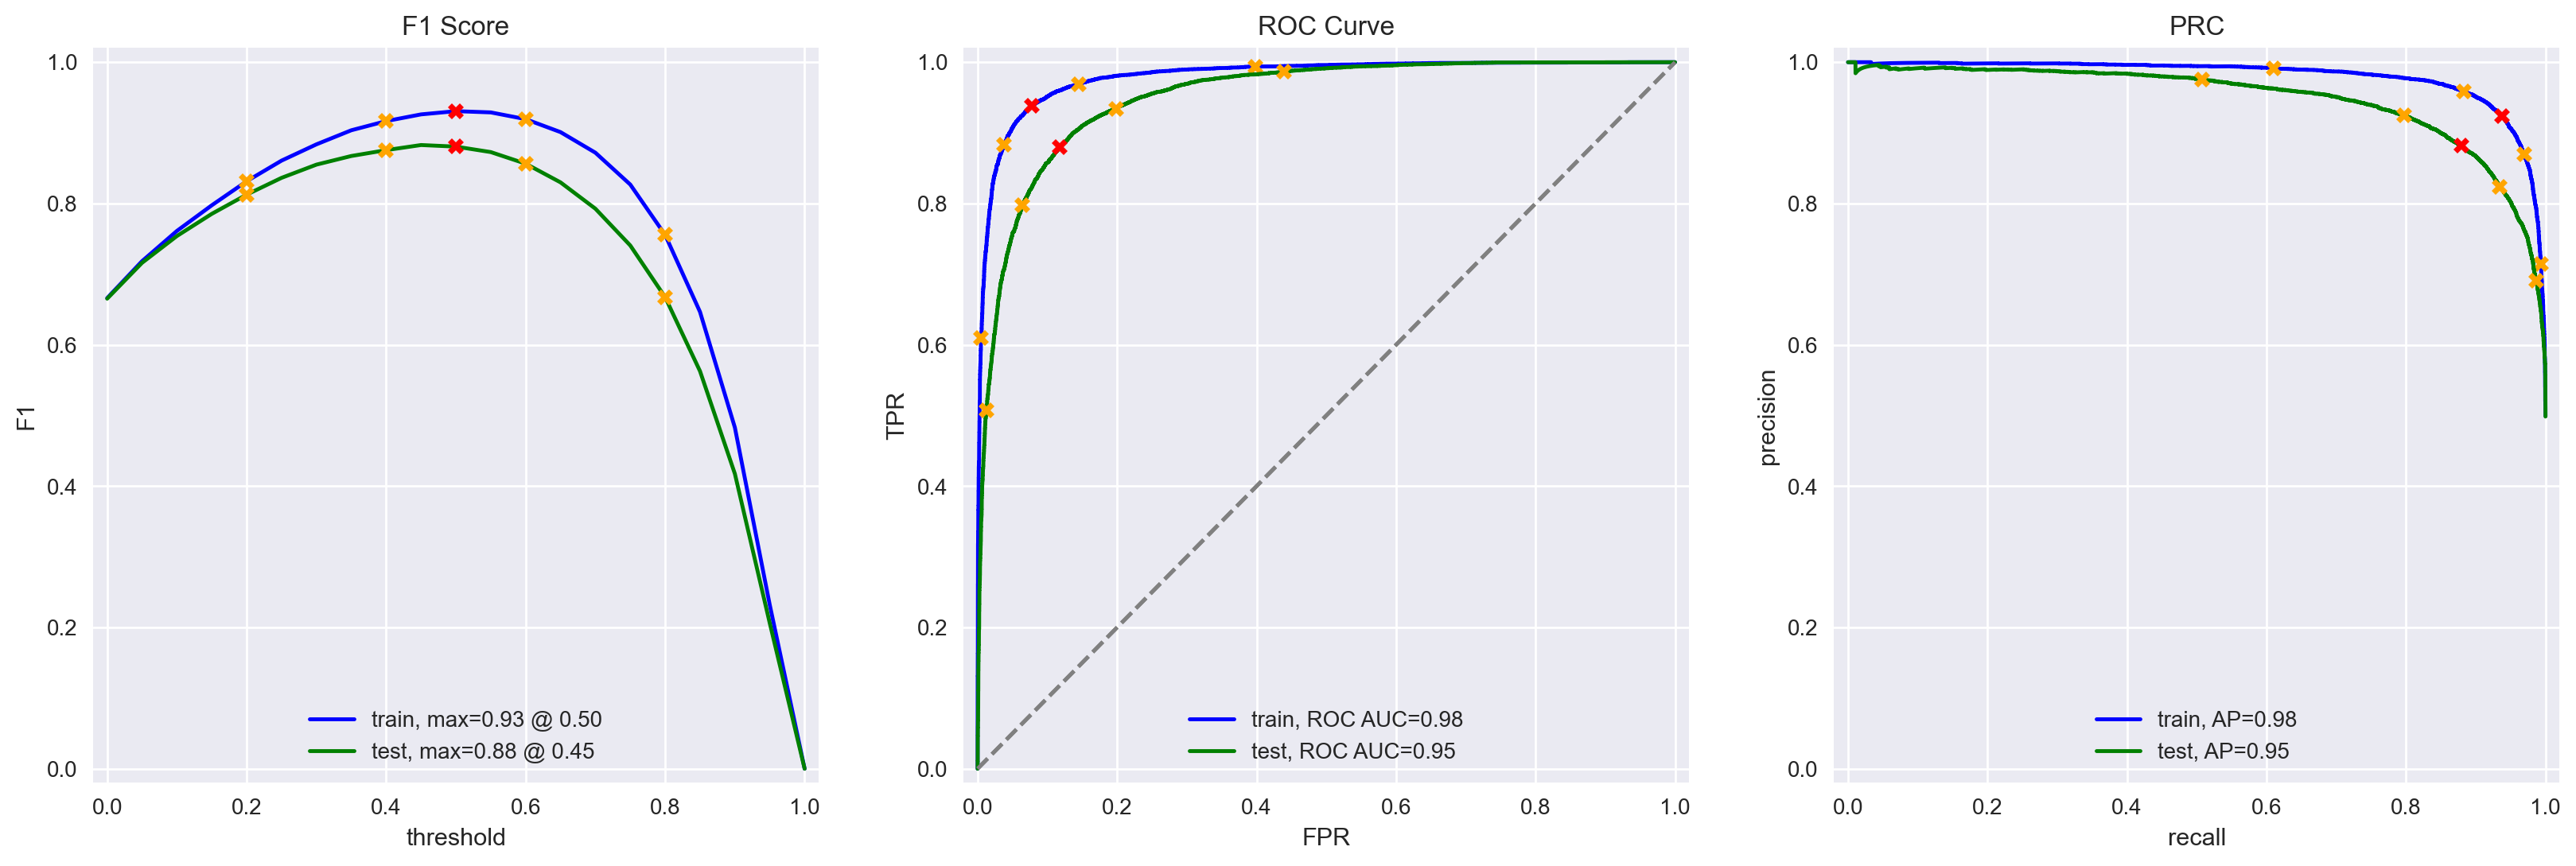

In [35]:
evaluate_model(best_lr_model, train_X, train_y, test_X, test_y)

### Model 3 - spaCy, TF-IDF and LR

In [36]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [37]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [38]:
%%time
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
df_reviews_train['reviews_spacy'] = df_reviews_train['reviews_norm'].apply(text_preprocessing_3)
df_reviews_test['reviews_spacy'] = df_reviews_test['reviews_norm'].apply(text_preprocessing_3)

CPU times: user 9min 7s, sys: 347 ms, total: 9min 7s
Wall time: 9min 7s


In [39]:
train_X = tfidf_vectorizer_3.fit_transform(df_reviews_train['reviews_spacy'])
test_X = tfidf_vectorizer_3.transform(df_reviews_test['reviews_spacy'])

In [40]:
lr = LogisticRegression()
best_lr_spacy_model, best_lr_spacy_f1, best_lr_spacy_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

In [41]:
best_lr_spacy_f1

0.8786564625850339

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


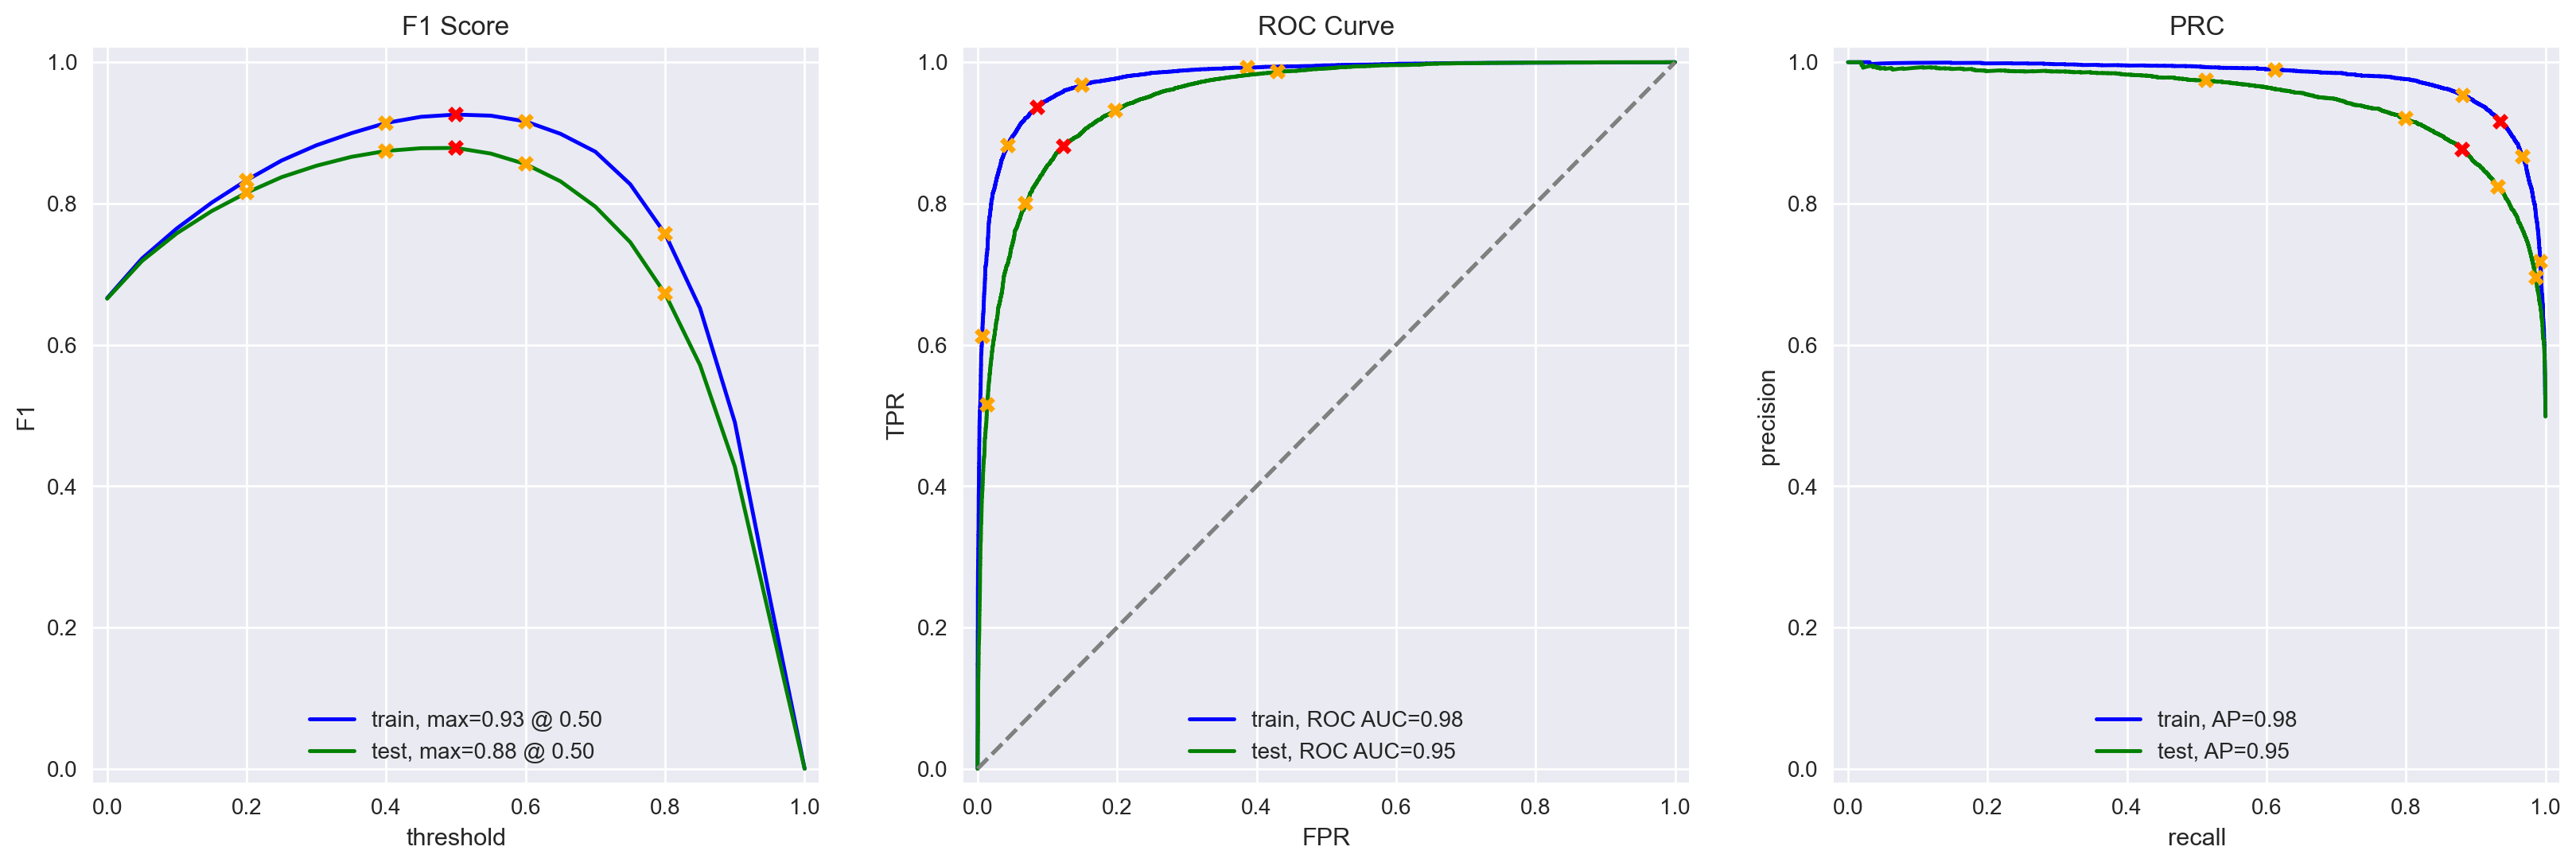

In [42]:
evaluate_model(best_lr_spacy_model, train_X, train_y, test_X, test_y)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [43]:
lgbm = LGBMClassifier(learning_rate=0.1, boosting_type='gbdt',
                      objective='binary',
                      feature_fraction=0.8,
                      random_state=42)
best_lgbm_model, best_lgbm_f1, best_lgbm_time = build_model(lgbm, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'n_estimators': range(100, 600, 100)}, 
                scoring='f1_weighted', cv=3, model_str='lgbm',
           cat_features=[])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGB

In [44]:
best_lgbm_f1

0.8706493064420049

          train  test
Accuracy   0.99  0.87
F1         0.99  0.87
APS        1.00  0.94
ROC AUC    1.00  0.95


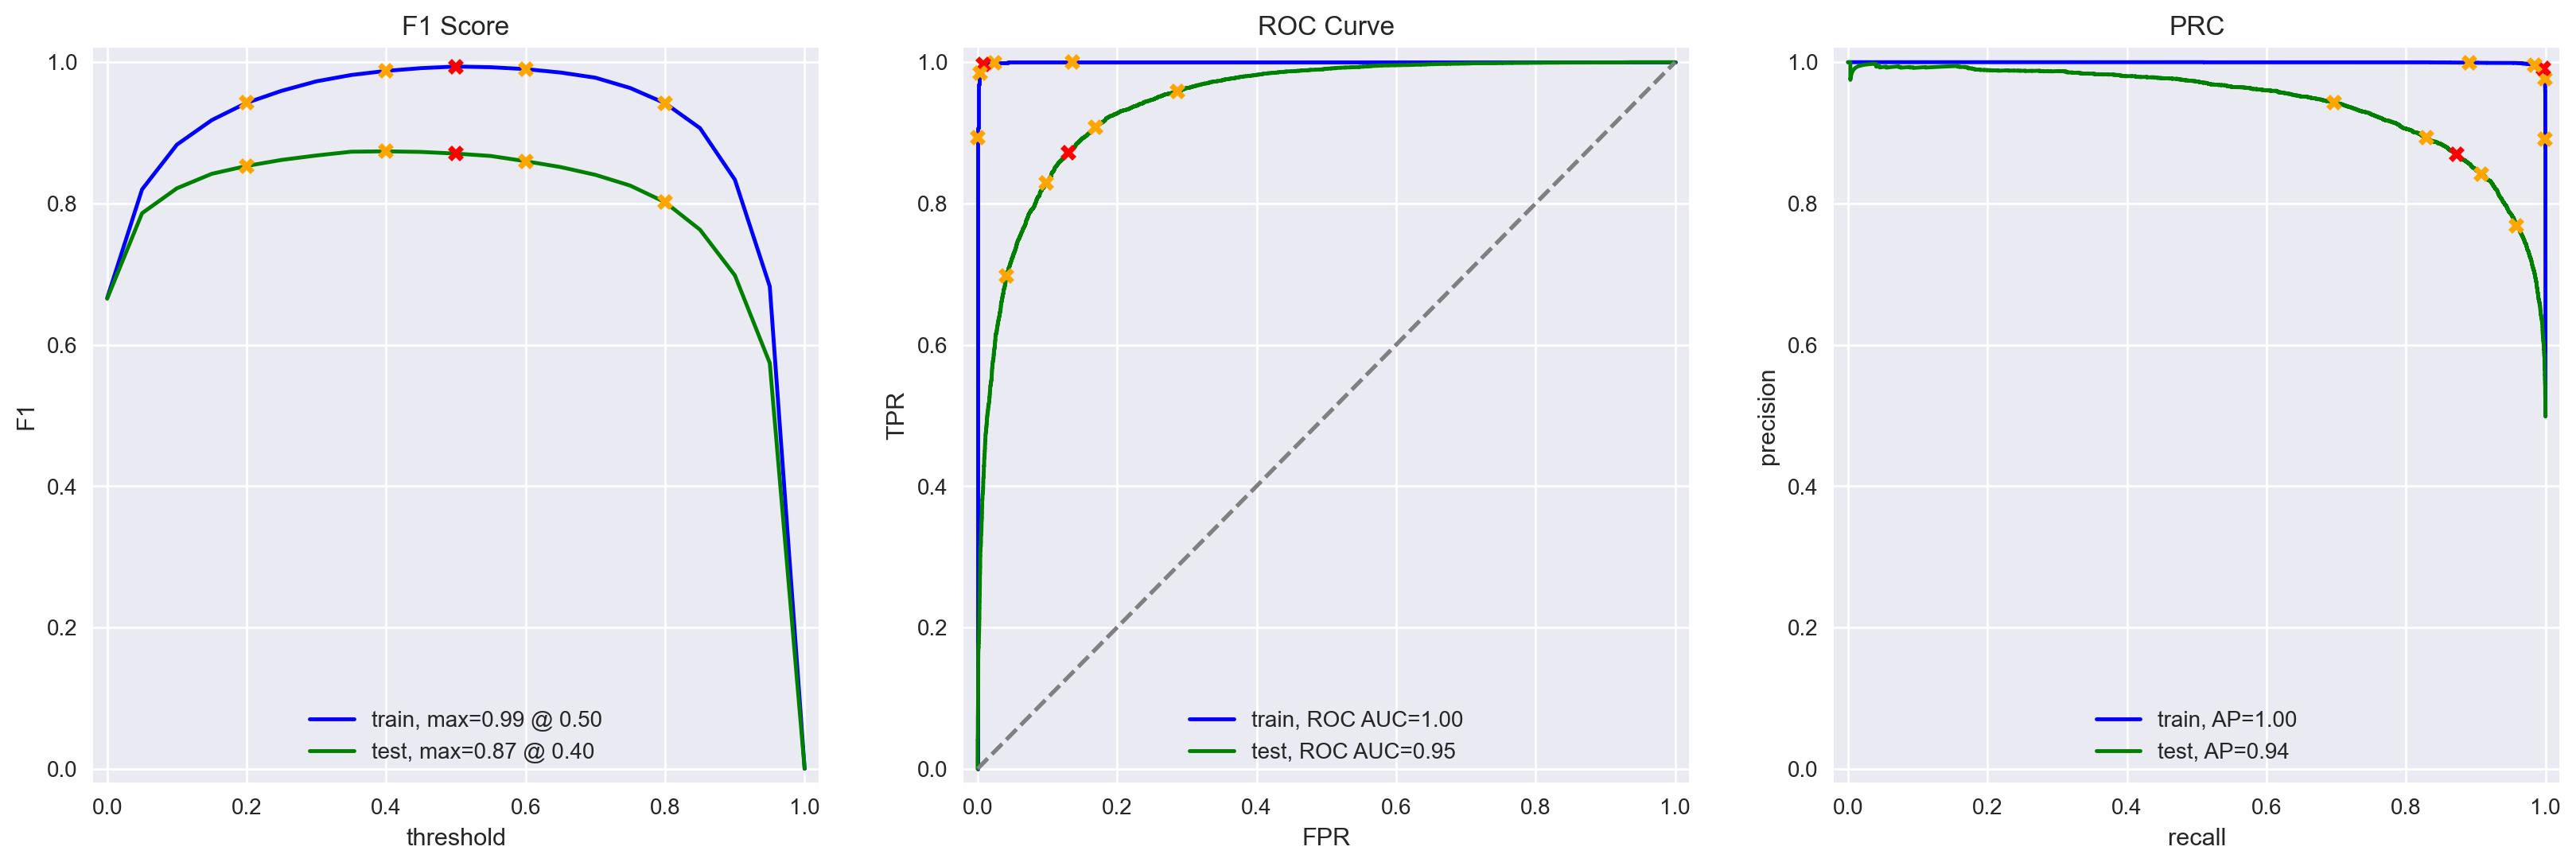

In [45]:
evaluate_model(best_lgbm_model, train_X, train_y, test_X, test_y)

###  Model 9 - BERT

In [62]:
model_results_df = pd.DataFrame({'Model': ['LogisticRegression-NLTK', 'LogisticRegression-Spacy', 'LGBMClassifier'],
                                 'best_f1': [best_lr_f1, best_lr_spacy_f1, best_lgbm_f1],
                                 'train_time': [best_lr_time, best_lr_spacy_time, best_lgbm_time]})

In [63]:
model_results_df

,Model,best_f1,train_time
0,LogisticRegression-NLTK,0.880515,8.14
1,LogisticRegression-Spacy,0.878656,7.81
2,LGBMClassifier,0.870649,424.60


### Observations:
* Comparing the LogisticRegression models with NLTK used for preprocessing and Spacy for preprocessing, the model with reviews preprocesed using NLTK, comes out at the top with best f1 score of 88%. 

## My Reviews

In [65]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clean_reviews)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [68]:
texts = my_reviews['review_norm']

model_2 = best_lr_model

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  i did not simply like it not my kind of movie 
0.18:  well i was bored and felt asleep in the middle of the movie 
0.60:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.33:  i didn't expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [70]:
texts = my_reviews['review_norm']

model_3 = best_lr_spacy_model

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.22:  i did not simply like it not my kind of movie 
0.13:  well i was bored and felt asleep in the middle of the movie 
0.52:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.20:  i didn't expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [72]:
texts = my_reviews['review_norm']

model_4 = best_lgbm_model 

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.53:  i did not simply like it not my kind of movie 
0.26:  well i was bored and felt asleep in the middle of the movie 
0.60:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.32:  i didn't expect the reboot to be so good writers really cared about the source material
0.78:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.11:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [73]:
model_results_df

,Model,best_f1,train_time
0,LogisticRegression-NLTK,0.880515,8.14
1,LogisticRegression-Spacy,0.878656,7.81
2,LGBMClassifier,0.870649,424.60


## Conclusions

* With the choice of not doing BERT due to computational limitations as mentioned in the project instructions, I proceeded using other methods including NLTK, Spacy, and LGBMClassifier. NLTK has the best f1 score with .88 which is higher than the required .85 in this project. 